In [1]:
import sys
sys.path.append('../MovingMNIST/')

In [2]:
import csv
import glob
import math
import os
import random

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn import init
from tqdm import tqdm

from MovingMNIST import MovingMNIST

/home/nakai-yu/dev/imsegnet/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 64


In [4]:
train_set = MovingMNIST(root='.data/mnist', train=True, download=True)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True)

In [5]:
test_set = MovingMNIST(root='.data/mnist', train=False, download=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False)


In [6]:
[(x.shape, x.dtype) for x in next(iter(train_loader))]

[(torch.Size([64, 10, 64, 64]), torch.uint8),
 (torch.Size([64, 10, 64, 64]), torch.uint8)]

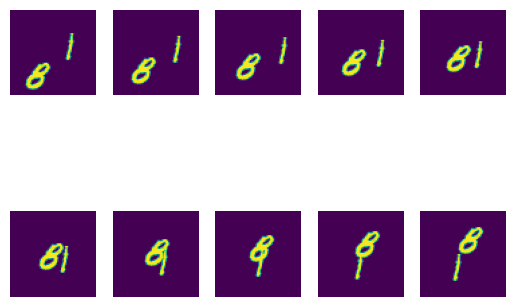

In [7]:
fig = plt.figure()

num = 0
row = 2
col = 5

test = next(iter(train_loader))

while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(test[0][0, num - 1])
    plt.axis('off')

In [8]:

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):        
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y



def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N]


class Encoder(nn.Module):
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )
    
    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)
    
    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y


class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, H, W = shape_in
        self.enc = Encoder(1, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, 1, N_S)


    def forward(self, x_raw):
        B, T, H, W = x_raw.shape
        x = x_raw.view(B*T, 1, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, H, W)
        return Y



In [19]:
net = SimVP((10, 64, 64), incep_ker=[3,5])

In [20]:
lrate = 0.01
epochs = 100
weight_decay = 5e-7
start_decay = 10
path2save = "./checkpoint/simvp_{}_3.pt"

criterion = nn.MSELoss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(" GPU is activated" if device else " CPU is activated")

net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lrate, weight_decay=weight_decay)

for epoch in range(epochs):
    train_loss = []

    net.train()
    for x, t in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)

        y = net(x.float())

        loss = criterion(y, t.float())

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item() / batch_size)
    
    avg_train_loss = np.average(train_loss)

    test_loss = []

    net.eval()
    with torch.no_grad():
        for x, t in test_loader:
            x = x.to(device)
            t = t.to(device)

            y = net(x.float())

            loss = criterion(y, t.float())

            test_loss.append(loss.item() / batch_size)
    
    avg_test_loss = np.average(test_loss)

    log_info = (epoch + 1, epochs, avg_train_loss, avg_test_loss)

    print('[Epoch %d/%d]  MSELoss [Train] %.3f [Test] %.3f' % log_info)
    
    if (epoch + 1) % 10 == 0:
        torch.save(net, path2save.format(epoch + 1))
    
    with open('./infor/simvp_t1_3.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(log_info)
    

 GPU is activated
[Epoch 1/100]  MSELoss [Train] 35.826 [Test] 31.693
[Epoch 2/100]  MSELoss [Train] 30.733 [Test] 29.821
[Epoch 3/100]  MSELoss [Train] 29.487 [Test] 29.256
[Epoch 4/100]  MSELoss [Train] 28.631 [Test] 28.255
[Epoch 5/100]  MSELoss [Train] 27.984 [Test] 27.757
[Epoch 6/100]  MSELoss [Train] 27.248 [Test] 27.208
[Epoch 7/100]  MSELoss [Train] 26.712 [Test] 26.694
[Epoch 8/100]  MSELoss [Train] 26.201 [Test] 26.382
[Epoch 9/100]  MSELoss [Train] 25.751 [Test] 25.921
[Epoch 10/100]  MSELoss [Train] 25.352 [Test] 25.349
[Epoch 11/100]  MSELoss [Train] 24.903 [Test] 25.112
[Epoch 12/100]  MSELoss [Train] 24.619 [Test] 24.911
[Epoch 13/100]  MSELoss [Train] 24.228 [Test] 24.539
[Epoch 14/100]  MSELoss [Train] 23.957 [Test] 24.495
[Epoch 15/100]  MSELoss [Train] 23.683 [Test] 24.095
[Epoch 16/100]  MSELoss [Train] 23.368 [Test] 24.080
[Epoch 17/100]  MSELoss [Train] 23.144 [Test] 23.722
[Epoch 18/100]  MSELoss [Train] 22.897 [Test] 23.548
[Epoch 19/100]  MSELoss [Train] 22.63

KeyboardInterrupt: 

In [21]:
x, t = next(iter(test_loader))

In [22]:
len(x)

64

In [23]:
net.eval()
with torch.no_grad():
    x = x.to(device)
    y = net(x.float()).cpu()

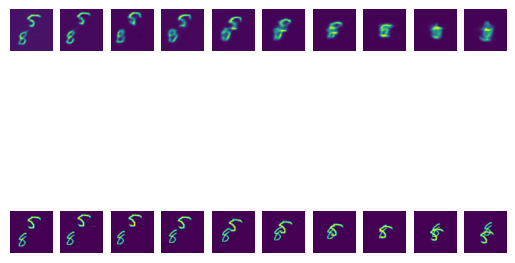

In [24]:
fig = plt.figure()

num = 0
row = 2
col = 10

for num in range(col):
    plt.subplot(row, col, num + 1)
    plt.imshow(y[0, num])
    plt.axis('off')

for num in range(col):
    plt.subplot(row, col, col + num + 1)
    plt.imshow(t[0, num])
    plt.axis('off')

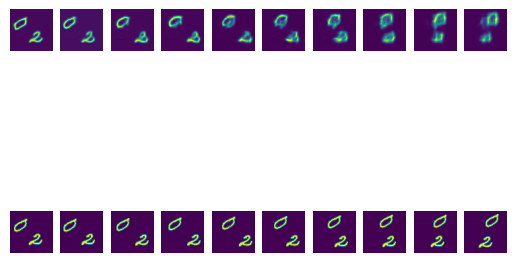

In [25]:
fig = plt.figure()

num = 0
row = 2
col = 10

for num in range(col):
    plt.subplot(row, col, num + 1)
    plt.imshow(y[5, num])
    plt.axis('off')

for num in range(col):
    plt.subplot(row, col, col + num + 1)
    plt.imshow(t[5, num])
    plt.axis('off')

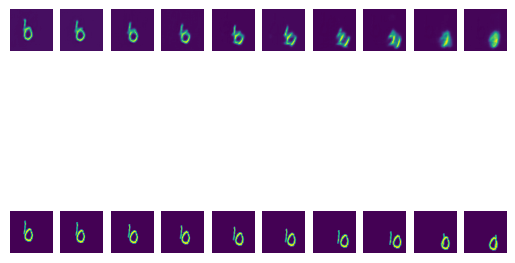

In [26]:
fig = plt.figure()

num = 0
row = 2
col = 10

for num in range(col):
    plt.subplot(row, col, num + 1)
    plt.imshow(y[10, num])
    plt.axis('off')

for num in range(col):
    plt.subplot(row, col, col + num + 1)
    plt.imshow(t[10, num])
    plt.axis('off')